# 人脸识别

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年1月4日 | Rui | 初次编写文档 | ---- |
| 2022年1月8日 | dianjixz | 修改文档的编写方式<br>调整[源码](https://github.com/sipeed/MaixPy3_scripts/blob/master/scripts/nn_face_recognition.py)结构<br>调整运行逻辑 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |

## 运行效果

<iframe src="//player.bilibili.com/player.html?aid=714915927&bvid=BV1MX4y1g7cE&cid=321380350&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>

## 准备

- 在 [MaixHub](https://www.maixhub.com/modelInfo?modelId=24) 上获取模型文件和运行源码（最新版本的系统内置了模型文件 `/home/model/face_recognize/*`）
- 确认 MaixPy3 版本为 0.4.0 以上
- 使用的硬件为 MaixII-Dock
- 内存卡内是最新版本的镜像系统
- 插卡启动硬件

## 人脸识别

将模型读取到python环境中！

In [1]:
class Face_recognize :
    score_threshold = 70                            #识别分数阈值
    input_size = (224, 224, 3)                      #输入图片尺寸
    input_size_fe = (128, 128, 3)                   #输入人脸数据
    feature_len = 256                               #人脸数据宽度
    steps = [8, 16, 32]                             #
    channel_num = 0                                 #通道数量
    users = []                                      #初始化用户列表
    threshold = 0.5                                         #人脸阈值
    nms = 0.3                                               
    max_face_num = 2                                        #输出的画面中的人脸的最大个数
    names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]  #人脸标签定义
    model = {                                                                                                                                   
        "param": "/home/model/face_recognize/model_int8.param",
        "bin": "/home/model/face_recognize/model_int8.bin"
    }
    model_fe = {
        "param": "/home/model/face_recognize/fe_res18_117.param",
        "bin": "/home/model/face_recognize/fe_res18_117.bin"
    }
    def __init__(self):
        from maix import nn, camera, image, display
        from maix.nn.app.face import FaceRecognize
        for i in range(len(self.steps)):
            self.channel_num += self.input_size[1] / self.steps[i] * (self.input_size[0] / self.steps[i]) * 2
        self.channel_num = int(self.channel_num)     #统计通道数量
        self.options = {                             #准备人脸输出参数
            "model_type":  "awnn",
            "inputs": {
                "input0": self.input_size
            },
            "outputs": {
                "output0": (1, 4, self.channel_num) ,
                "431": (1, 2, self.channel_num) ,
                "output2": (1, 10, self.channel_num) 
            },
            "mean": [127.5, 127.5, 127.5],
            "norm": [0.0078125, 0.0078125, 0.0078125],
        }
        self.options_fe = {                             #准备特征提取参数
            "model_type":  "awnn",
            "inputs": {
                "inputs_blob": self.input_size_fe
            },
            "outputs": {
                "FC_blob": (1, 1, self.feature_len)
            },
            "mean": [127.5, 127.5, 127.5],
            "norm": [0.0078125, 0.0078125, 0.0078125],
        }
        print("-- load model:", self.model)
        self.m = nn.load(self.model, opt=self.options)
        print("-- load ok")
        print("-- load model:", self.model_fe)
        self.m_fe = nn.load(self.model_fe, opt=self.options_fe)
        print("-- load ok")
        self.face_recognizer = FaceRecognize(self.m, self.m_fe, self.feature_len, self.input_size, self.threshold, self.nms, self.max_face_num)

    def map_face(self, box,points):                           #将224*224空间的位置转换到240*240空间内
        def tran(x):
            return int(x/224*240)
        box = list(map(tran, box))
        def tran_p(p):
            return list(map(tran, p))
        points = list(map(tran_p, points))
        return box,points

    def recognize(self, feature):                                                                   #进行人脸匹配
        def _compare(user):                                                         #定义映射函数
            return self.face_recognizer.compare(user, feature)                      #推测匹配分数 score相关分数
        face_score_l = list(map(_compare,self.users))                               #映射特征数据在记录中的比对分数
        return max(enumerate(face_score_l), key=lambda x: x[-1])                #提取出人脸分数最大值和最大值所在的位置

    
    
    
    def __del__(self):
        del self.face_recognizer
        del self.m_fe
        del self.m

global face_recognizer
face_recognizer = Face_recognize()

[ rpyc-kernel ]( running at Thu Jan 20 10:00:04 2022 )
-- load model: {'param': '/home/model/face_recognize/model_int8.param', 'bin': '/home/model/face_recognize/model_int8.bin'}
-- load ok
-- load model: {'param': '/home/model/face_recognize/fe_res18_117.param', 'bin': '/home/model/face_recognize/fe_res18_117.bin'}
-- load ok


寻找人脸！

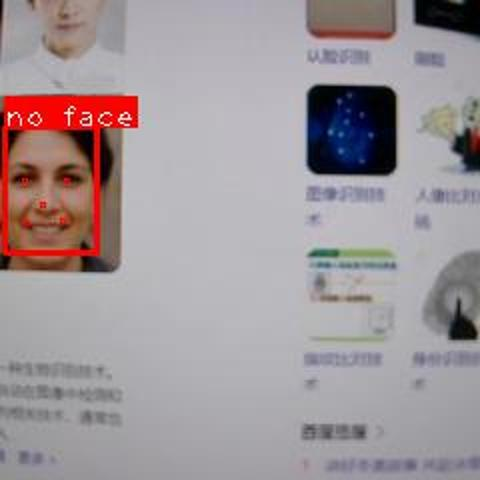


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import camera, image, display
while True:
    img = camera.capture()                       #获取224*224*3的图像数据
    AI_img = img.copy().resize(224, 224)
    faces = face_recognizer.face_recognizer.get_faces(AI_img.tobytes(),False)           #提取人脸特征信息
    
    if faces:
        for prob, box, landmarks, feature in faces:
            disp_str = "no face"
            bg_color = (255, 0, 0)
            font_color=(255, 255, 255)
            box,points = face_recognizer.map_face(box,landmarks)
            font_wh = img.get_string_size(disp_str)
            for p in points:
                img.draw_rectangle(p[0] - 1, p[1] -1, p[0] + 1, p[1] + 1, color=bg_color)
            img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color=bg_color, thickness=2)
            img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color=bg_color, thickness = -1)
            img.draw_string(box[0], box[1] - font_wh[1], disp_str, color=font_color)
    display.show(img)

添加一张人脸！

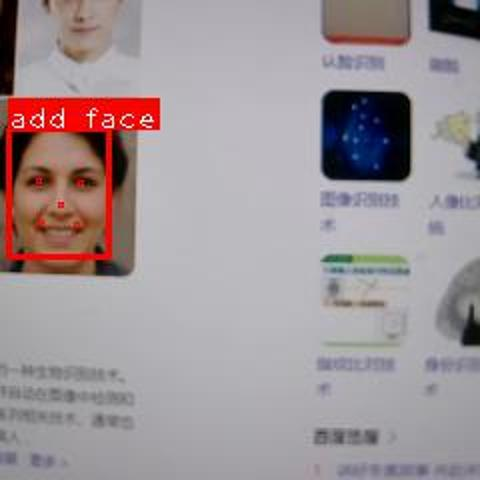

In [1]:
from maix import camera, image, display
face_flage = 1
while face_flage:
    img = camera.capture()                       #获取224*224*3的图像数据
    AI_img = img.copy().resize(224, 224)
    faces = face_recognizer.face_recognizer.get_faces(AI_img.tobytes(),False)           #提取人脸特征信息
    
    if faces:
        for prob, box, landmarks, feature in faces:
            if len(face_recognizer.users) < len(face_recognizer.names):
                face_recognizer.users.append(feature)
                face_flage = 0
            else:
                print("user full")
            disp_str = "add face"
            bg_color = (255, 0, 0)
            font_color=(255, 255, 255)
            box,points = face_recognizer.map_face(box,landmarks)
            font_wh = img.get_string_size(disp_str)
            for p in points:
                img.draw_rectangle(p[0] - 1, p[1] -1, p[0] + 1, p[1] + 1, color=bg_color)
            img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color=bg_color, thickness=2)
            img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color=bg_color, thickness = -1)
            img.draw_string(box[0], box[1] - font_wh[1], disp_str, color=font_color)
    display.show(img)

删除一张人脸！

In [ ]:
if len(face_recognizer.users) > 0:
    print("remove user:", face_recognizer.names[len(face_recognizer.users) - 1])
    face_recognizer.users.pop()
else:
    print("user empty")

识别人脸！

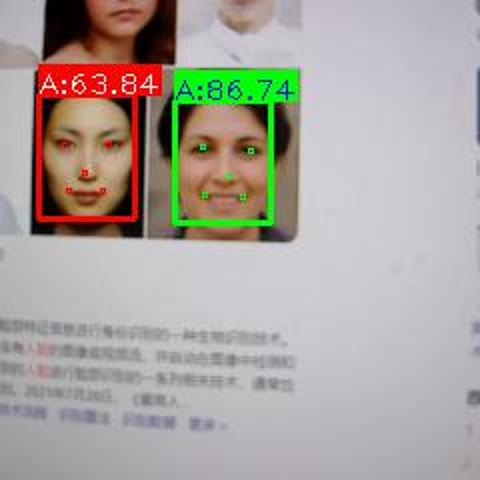


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import camera, image, display




while True:
    img = camera.capture()                       #获取224*224*3的图像数据
    AI_img = img.copy().resize(224, 224)
    faces = face_recognizer.face_recognizer.get_faces(AI_img.tobytes(),False)           #提取人脸特征信息
    
    if faces:
        for prob, box, landmarks, feature in faces:
            if len(face_recognizer.users):                             #判断是否记录人脸
                maxIndex = face_recognizer.recognize(feature)

                if maxIndex[1] > face_recognizer.score_threshold:                                      #判断人脸识别阈值,当分数大于阈值时认为是同一张脸,当分数小于阈值时认为是相似脸
                    disp_str = "{}:{:.2f}".format(face_recognizer.names[maxIndex[0]], maxIndex[1])
                    bg_color = (0, 255, 0)
                    font_color=(0, 0, 255)
                    box,points = face_recognizer.map_face(box,landmarks)
                    font_wh = img.get_string_size(disp_str)
                    for p in points:
                        img.draw_rectangle(p[0] - 1, p[1] -1, p[0] + 1, p[1] + 1, color=bg_color)
                    img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color=bg_color, thickness=2)
                    img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color=bg_color, thickness = -1)
                    img.draw_string(box[0], box[1] - font_wh[1], disp_str, color=font_color)  
                else:
                    disp_str = "{}:{:.2f}".format(face_recognizer.names[maxIndex[0]], maxIndex[1])
                    bg_color = (255, 0, 0)
                    font_color=(255, 255, 255)
                    box,points = face_recognizer.map_face(box,landmarks)
                    font_wh = img.get_string_size(disp_str)
                    for p in points:
                        img.draw_rectangle(p[0] - 1, p[1] -1, p[0] + 1, p[1] + 1, color=bg_color)
                    img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color=bg_color, thickness=2)
                    img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color=bg_color, thickness = -1)
                    img.draw_string(box[0], box[1] - font_wh[1], disp_str, color=font_color)  
            else:                                           #没有记录脸                
                disp_str = "no face"
                bg_color = (255, 0, 0)
                font_color=(255, 255, 255)
                box,points = face_recognizer.map_face(box,landmarks)
                font_wh = img.get_string_size(disp_str)
                for p in points:
                    img.draw_rectangle(p[0] - 1, p[1] -1, p[0] + 1, p[1] + 1, color=bg_color)
                img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color=bg_color, thickness=2)
                img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color=bg_color, thickness = -1)
                img.draw_string(box[0], box[1] - font_wh[1], disp_str, color=font_color)
    display.show(img)

人脸保存！

In [1]:
import pickle
with open("/root/face_data.pickle",'wb') as f:
    pickle.dump(face_recognizer.users, f)

[ rpyc-kernel ]( running at Wed Jan 19 18:13:25 2022 )


加载人脸信息！

In [ ]:
import pickle
with open("/root/face_data.pickle",'rb')as f:
    face_recognizer.users = pickle.load(f)

> 运行[完整脚本代码](https://github.com/sipeed/MaixPy3_scripts/blob/master/scripts/nn_face_recognition.py)可以通过按键控制多个人脸的信息添加、识别